In [1]:
# env_name = 'Acrobot-v1'

env_name = 'ALE/Assault-ram-v5'

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import time
import pickle

# Hyperparameters

EPISODES = 1000
MAX_STEPS = 1000
GAMMA = 0.99
HIDDEN_DIM = 256
SEEDS = 10

# Environment

env = gym.make(env_name)
env._max_episode_steps = MAX_STEPS

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = "mps"

# Neural Network

class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, action_dim)
    # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                print("initializing layer", m)
                nn.init.uniform_(m.weight, -0.01, 0.01)
                nn.init.uniform_(m.bias, -0.01, 0.01)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Q-Learning

def q_learning(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
# q_network_target = QNetwork()
# q_network_target.load_state_dict(q_network.state_dict())
    q_network.to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        steps = 0
        while not done and steps < MAX_STEPS:
            steps += 1
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
        # next_q_values = q_network_target(next_state_batch)
                next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
# for i in range(batch_size):
#     target_q_values[i][action_batch[i]] = reward_batch[i] + GAMMA * next_q_values[i].max() * (1 - done_batch[i])
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * next_q_values.max(dim=1).values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 100 == 0:
        # q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())


    return rewards


# Expected SARSA

def expected_sarsa(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
# q_network_target = QNetwork()
# q_network_target.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        steps = 0
        while not done and steps < MAX_STEPS:
            steps += 1
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                # next_q_values = q_network_target(next_state_batch)
                next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # expected sarsa
                probs = torch.ones(batch_size, action_dim) * epsilon / action_dim
                probs[range(batch_size), next_q_values.argmax(dim=1)] += 1 - epsilon
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * (probs * next_q_values).sum(dim=1) * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 100 == 0:
    #     q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())
    return rewards


def run_experiment(lr, batch_size, replay_buffer_size, epsilon):
    random_seeds = [1, 2, 3, 4, 5, 6, 8, 11, 12]
    q_learning_rewards = np.zeros((SEEDS, EPISODES))
    expected_sarsa_rewards = np.zeros((SEEDS, EPISODES))
    if os.path.exists(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        q_learning_rewards = pickle.load(open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
    if os.path.exists(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        expected_sarsa_rewards = pickle.load(open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
# for i, seed in enumerate(random_seeds):
    for i in range(SEEDS):
        print(f'Run {i+1}/{SEEDS}')
        if q_learning_rewards[i].sum() != 0 and expected_sarsa_rewards[i].sum() != 0:
            continue
        np.random.seed(random_seeds[i])
        torch.manual_seed(random_seeds[i])
        print('Q-Learning')
        q_learning_rewards[i] = q_learning(lr, batch_size, replay_buffer_size, epsilon)
        print('Expected SARSA')
        expected_sarsa_rewards[i] = expected_sarsa(lr, batch_size, replay_buffer_size, epsilon)
        q_learning_rewards_mean = q_learning_rewards[:i+1].mean(axis=0)
        q_learning_rewards_std = q_learning_rewards[:i+1].std(axis=0)/np.sqrt(i+1)
        expected_sarsa_rewards_mean = expected_sarsa_rewards[:i+1].mean(axis=0)
        expected_sarsa_rewards_std = expected_sarsa_rewards[:i+1].std(axis=0)/np.sqrt(i+1)
        plt.plot(q_learning_rewards_mean, label='Q-Learning', color='green')
        plt.fill_between(range(EPISODES), q_learning_rewards_mean - q_learning_rewards_std, q_learning_rewards_mean + q_learning_rewards_std, color='green', alpha=0.2)
        plt.plot(expected_sarsa_rewards_mean, label='Expected SARSA', color='red')
        plt.fill_between(range(EPISODES), expected_sarsa_rewards_mean - expected_sarsa_rewards_std, expected_sarsa_rewards_mean + expected_sarsa_rewards_std, color='red', alpha=0.2)
        plt.title(f'lr={lr}, batch_size={batch_size}, replay_buffer_size={replay_buffer_size}, epsilon={epsilon}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig(f'plot_{i}_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.png')
        plt.show()
        pickle.dump(q_learning_rewards, open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        pickle.dump(expected_sarsa_rewards, open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))

/Users/Ile-Maurice/Library/Python/3.10/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 231.0 0.9860707521438599
100 336.0 1.4788480997085571
200 147.0 2.949147939682007
300 147.0 2.9524827003479004
400 168.0 0.982569694519043
500 189.0 1.9667021036148071
600 189.0 0.49151769280433655
700 252.0 0.9883034825325012
800 105.0 1.9648314714431763
900 189.0 0.4925519824028015
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 252.0 1.0692837238311768
100 189.0 0.4923851490020752
200 336.0 1.9632225036621094
300 399.0 0.9816655516624451
400 168.0 2.949450969696045
500 252.0 0.9812793135643005
600 189.0 1.4849815368652344
700 210.0 1.4859355688095093
800 378.0 0.9939442873001099
900 357.0 0.49204200506210327


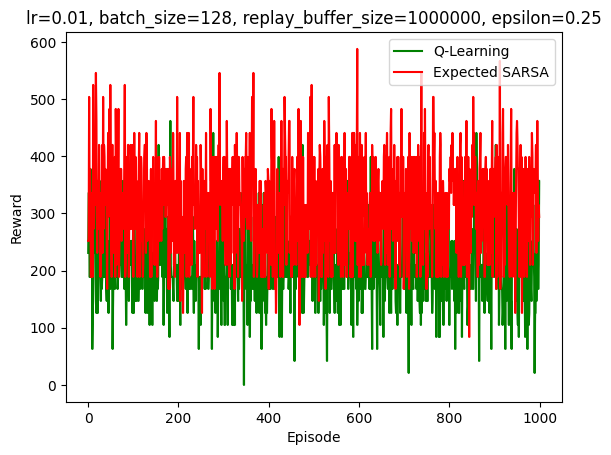

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.25_0.01_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 315.0 0.0007604802958667278
100 168.0 0.5892863273620605
200 189.0 3.1004445552825928
300 231.0 0.0005150779616087675
400 189.0 0.0007577681681141257
500 84.0 0.0009752792539075017
600 168.0 11.672843933105469
700 168.0 14.96553897857666
800 126.0 6.178693183755968e-06
900 147.0 0.0020598210394382477
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 147.0 2.6461422748980112e-05
100 399.0 0.004639021586626768
200 189.0 0.13830846548080444
300 189.0 0.0007831126567907631
400 168.0 0.00078095548087731
500 105.0 0.742425262928009
600 294.0 0.5760505795478821
700 63.0 0.755178630352

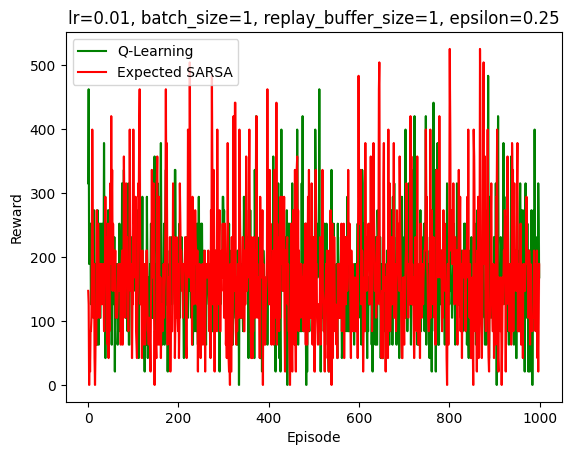

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.25_0.01_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 441.0 0.24360375106334686
100 294.0 0.09394824504852295
200 84.0 0.06954842805862427
300 252.0 0.06661099940538406
400 273.0 0.03080017678439617
500 210.0 0.07508686929941177
600 210.0 0.0796390250325203
700 357.0 0.08961153030395508
800 168.0 0.06797859072685242
900 63.0 0.060316748917102814
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 252.0 0.18005885183811188
100 105.0 0.08528482913970947
200 294.0 0.09259937703609467
300 273.0 0.1084626242518425
400 294.0 0.060703299939632416
500 273.0 0.054827239364385605
600 168.0 0.08047609776258469
700 210.0 0.06176137179136276
800

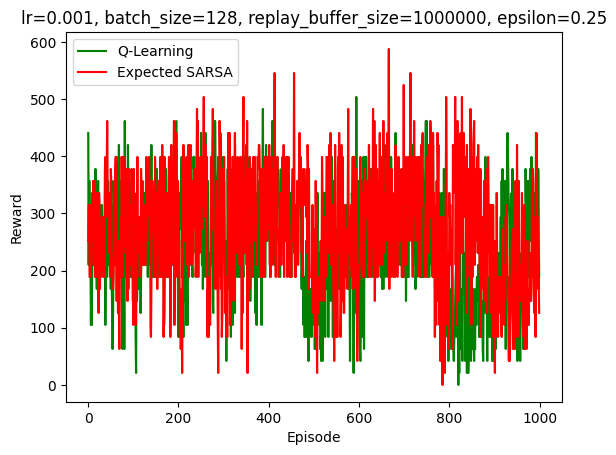

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.25_0.001_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.00014754878066014498
100 84.0 0.01452118344604969
200 315.0 0.00014286137593444437
300 252.0 0.08603193610906601
400 273.0 1.3951663277111948e-05
500 126.0 0.20256200432777405
600 168.0 2.6900219381786883e-05
700 168.0 0.3517484962940216
800 42.0 0.42696014046669006
900 357.0 1.248203489012667e-06
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.0027643803041428328
100 84.0 0.08179458230733871
200 189.0 0.006612840108573437
300 210.0 0.03188975527882576
400 126.0 0.10462968051433563
500 42.0 0.23601345717906952
600 252.0 6.999462584644789e-06
700 168.0 0.563851

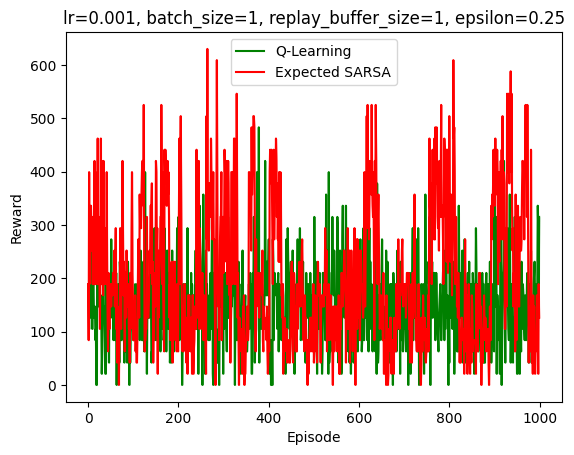

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.25_0.001_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 168.0 0.2171814888715744
100 420.0 0.0910298153758049
200 420.0 0.07038914412260056
300 315.0 0.05660169571638107
400 294.0 0.10922830551862717
500 84.0 0.03866324573755264
600 84.0 0.04325040429830551
700 105.0 0.059354133903980255
800 105.0 1.5203756093978882
900 63.0 0.04540985822677612
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 336.0 0.374989777803421
100 315.0 0.09875417500734329
200 189.0 0.08790593594312668
300 189.0 0.05821681022644043
400 525.0 0.08125492185354233
500 378.0 0.05159046873450279
600 189.0 0.03526625782251358
700 357.0 0.043372996151447296
800 273.

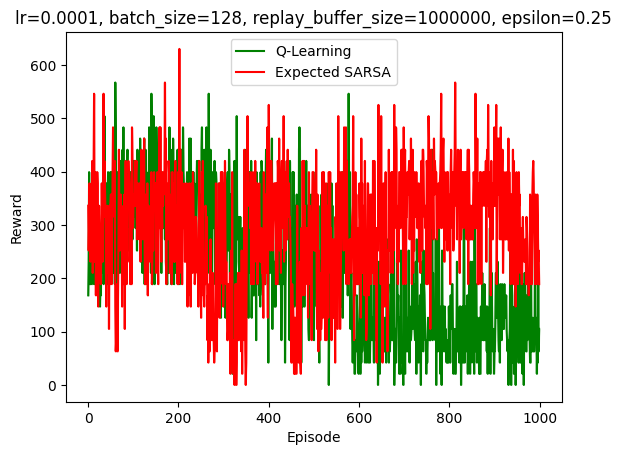

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.25_0.0001_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 210.0 0.018551882356405258
100 210.0 24.00395393371582
200 210.0 39.87392807006836
300 210.0 0.016817135736346245
400 189.0 0.14995984733104706
500 189.0 0.03955917805433273
600 336.0 0.022466197609901428
700 189.0 2.6251766030327417e-05
800 126.0 0.03955209627747536
900 189.0 0.05666513368487358
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 273.0 4.175269714323804e-05
100 336.0 27.387388229370117
200 273.0 12.853943824768066
300 189.0 3.6795289516448975
400 210.0 37.31854248046875
500 378.0 0.1904076784849167
600 336.0 15.421574592590332
700 210.0 22.799219131469727
800 39

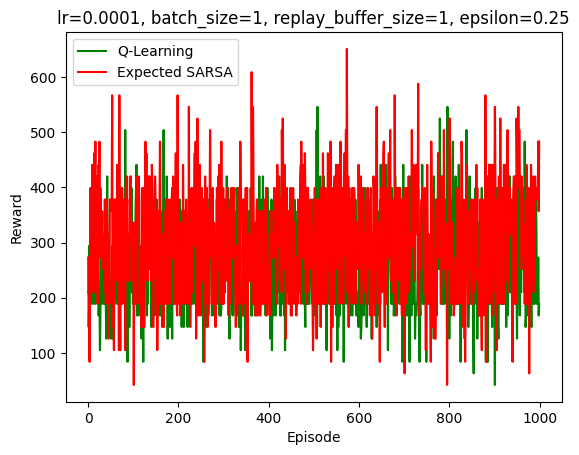

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.25_0.0001_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 84.0 0.9843938946723938
100 105.0 7.752759120194241e-05
200 210.0 1.4753965139389038
300 210.0 0.494081050157547
400 252.0 0.9834648370742798
500 189.0 0.4921243190765381
600 210.0 0.4924585223197937
700 84.0 1.4761039018630981
800 168.0 0.9827815890312195
900 189.0 1.9675447940826416
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 609.0 2.4543304443359375
100 462.0 2.4575819969177246
200 525.0 1.4724375009536743
300 357.0 2.4668171405792236
400 357.0 3.4309043884277344
500 210.0 1.4873980283737183
600 252.0 2.942251682281494
700 399.0 2.4724175930023193
800 273.0 2.462246656

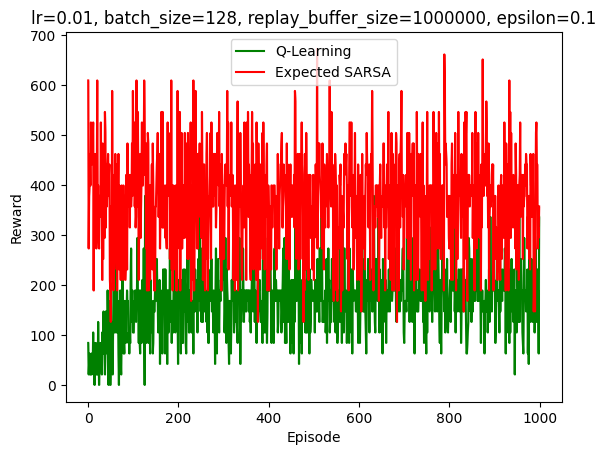

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.1_0.01_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 1.7334837565385897e-08
100 63.0 7.333061512326822e-05
200 0.0 2.5147461891174316
300 63.0 3.0670814514160156
400 63.0 0.00044075484038330615
500 126.0 0.00043352748616598547
600 63.0 4.923701286315918
700 84.0 6.0751118659973145
800 168.0 6.832276344299316
900 84.0 0.0007625881698913872
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.006620813626796007
100 105.0 4.971082307747565e-05
200 105.0 0.00014126638416200876
300 210.0 0.4217720627784729
400 42.0 0.5711275339126587
500 105.0 0.7035597562789917
600 189.0 1.028670072555542
700 189.0 0.7252592444419861
800 1

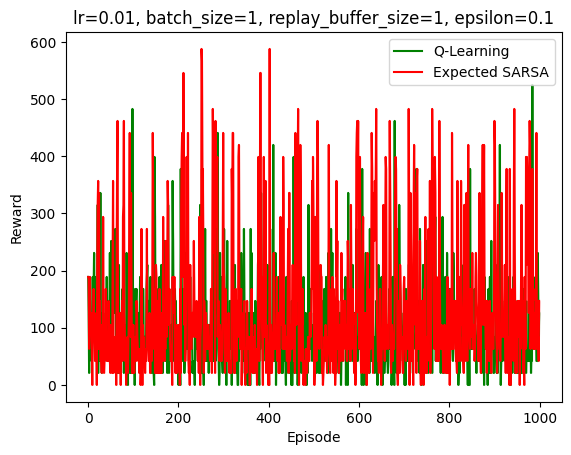

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.1_0.01_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.19179797172546387
100 294.0 0.10841886699199677
200 294.0 0.08581839501857758
300 399.0 0.16779546439647675
400 378.0 0.057663172483444214
500 147.0 0.06385261565446854
600 399.0 0.12037678062915802
700 315.0 0.15395809710025787
800 336.0 0.0944531038403511
900 399.0 0.11029373854398727
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 357.0 0.23281577229499817
100 378.0 0.08019223064184189
200 294.0 0.07801657170057297
300 399.0 0.1476459950208664
400 462.0 0.07362733036279678
500 420.0 0.13064344227313995
600 441.0 0.09371837228536606
700 462.0 0.11919261515140533
800

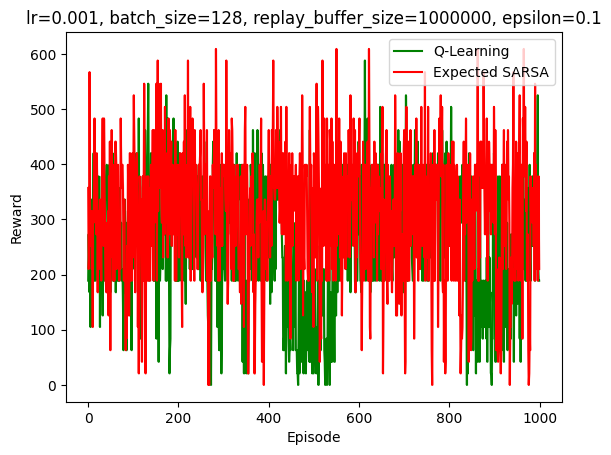

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.1_0.001_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 105.0 8.555614476790652e-05
100 0.0 0.06017366796731949
200 63.0 2.4868671971489675e-05
300 126.0 5.975085514364764e-05
400 168.0 4.7498284061475715e-07
500 0.0 2.654442548751831
600 63.0 0.00020804045198019594
700 105.0 0.00037485992652364075
800 42.0 2.9621927738189697
900 42.0 2.713144540786743
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 63.0 3.5220601990459954e-09
100 42.0 3.963595736422576e-05
200 315.0 0.001039518159814179
300 42.0 0.03646274283528328
400 357.0 0.08609874546527863
500 399.0 0.3225296139717102
600 441.0 0.4248359799385071
700 441.0 0.6193576455116272

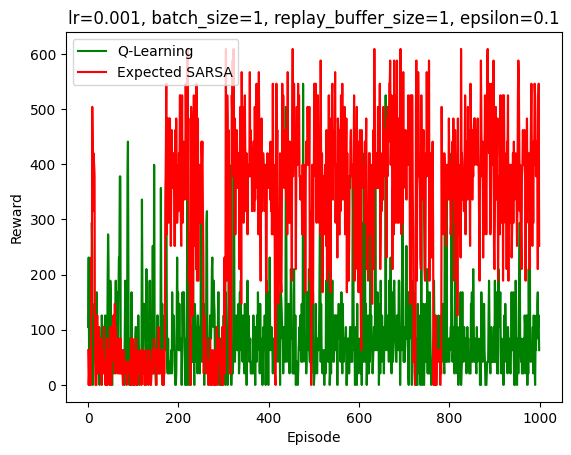

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.1_0.001_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 105.0 0.10320983827114105
100 189.0 0.05964008346199989
200 126.0 1.2951239347457886
300 231.0 0.03831695392727852
400 105.0 0.03357623144984245
500 273.0 0.032506056129932404
600 168.0 0.03833167627453804
700 315.0 0.0403343103826046
800 189.0 0.04001954197883606
900 357.0 0.03389713913202286
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 273.0 0.532457172870636
100 126.0 0.07370356470346451
200 294.0 0.050075821578502655
300 378.0 0.06522134691476822
400 441.0 0.12693575024604797
500 84.0 0.06693378835916519
600 0.0 0.05211281776428223
700 147.0 0.1593921035528183
800 273.

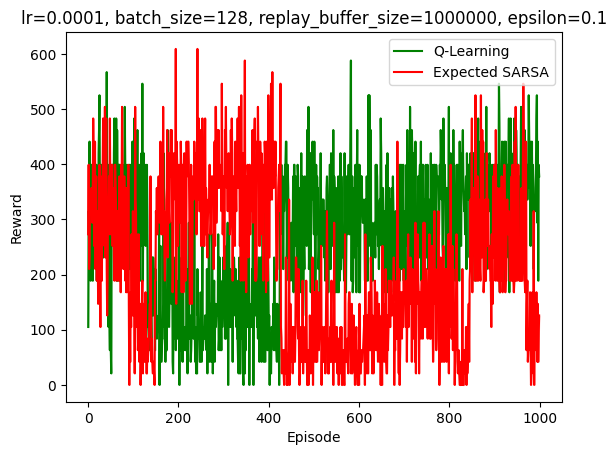

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.1_0.0001_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 126.0 0.0008886234136298299
100 399.0 0.07996147871017456
200 399.0 0.0029020451474934816
300 399.0 3.7325987815856934
400 189.0 0.002935081021860242
500 252.0 8.300471305847168
600 189.0 0.03055313415825367
700 273.0 11.717119216918945
800 399.0 0.03949802741408348
900 336.0 48.20458984375
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.00010978391946991906
100 336.0 33.61247634887695
200 420.0 0.010928436182439327
300 189.0 1.576206088066101
400 273.0 37.67178726196289
500 420.0 50.053627014160156
600 336.0 0.1163860335946083
700 399.0 15.736407279968262
800 378.0 0

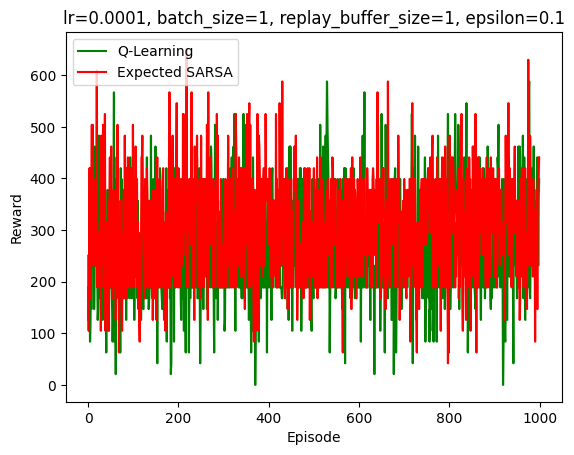

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.1_0.0001_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 21.0 2.058405334537383e-05
100 399.0 0.98316490650177
200 399.0 0.4907934367656708
300 441.0 0.9981696009635925
400 336.0 0.9834046959877014
500 441.0 0.4907285273075104
600 252.0 2.4890739917755127
700 315.0 1.9623262882232666
800 420.0 1.4725416898727417
900 84.0 1.4716097116470337
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 315.0 1.4763984680175781
100 525.0 0.490996390581131
200 357.0 1.4719159603118896
300 546.0 0.4906063973903656
400 483.0 1.962944746017456
500 399.0 3.4399657249450684
600 189.0 3.4320738315582275
700 420.0 1.9640716314315796
800 399.0 2.94357442855

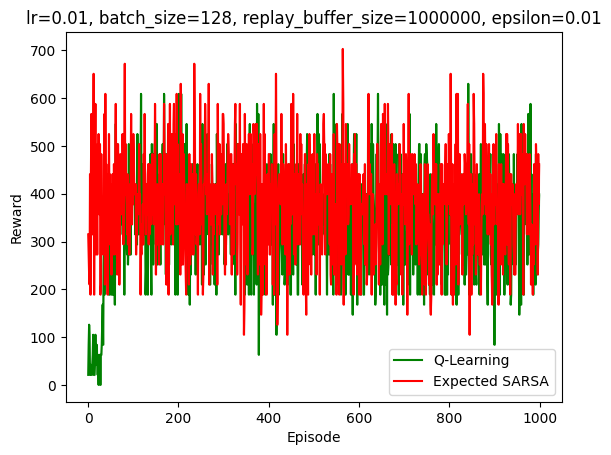

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.01_0.01_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 84.0 3.0813662306172773e-06
100 483.0 1.3263721466064453
200 0.0 2.3893983364105225
300 147.0 0.0002615567354951054
400 0.0 0.00026203496963717043
500 0.0 0.000301496620522812
600 0.0 1.8136810064315796
700 189.0 0.00028760317945852876
800 21.0 0.0002341081853955984
900 189.0 0.0002914672077167779
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 21.0 0.0012040308210998774
100 483.0 0.3052953779697418
200 0.0 0.2815991938114166
300 399.0 0.3626580834388733
400 21.0 7.078117778291926e-05
500 231.0 0.2841828465461731
600 42.0 0.07366253435611725
700 231.0 0.10174153000116348
800 

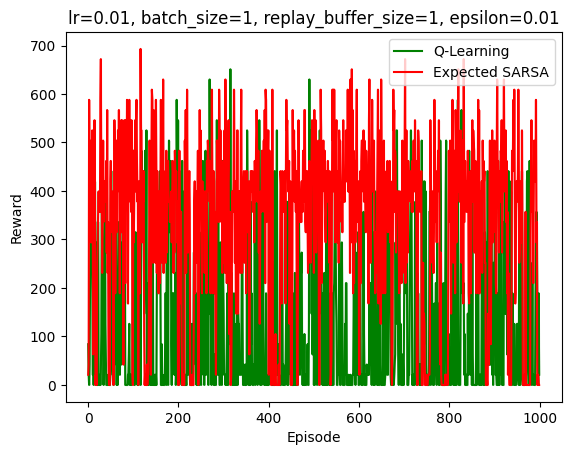

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.01_0.01_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 21.0 0.4835067391395569
100 399.0 0.05688991770148277
200 210.0 0.06977642327547073
300 63.0 0.05175567418336868
400 504.0 0.05129918456077576
500 252.0 0.06842461973428726
600 189.0 0.06551288813352585
700 189.0 0.4297139346599579
800 252.0 0.07573121041059494
900 252.0 0.06290733069181442
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 231.0 0.2586716413497925
100 357.0 0.1245030015707016
200 210.0 0.07614807039499283
300 42.0 0.05761796981096268
400 399.0 0.06781259924173355
500 42.0 0.09149368852376938
600 420.0 0.08067022264003754
700 315.0 0.0551084503531456
800 315.0 0

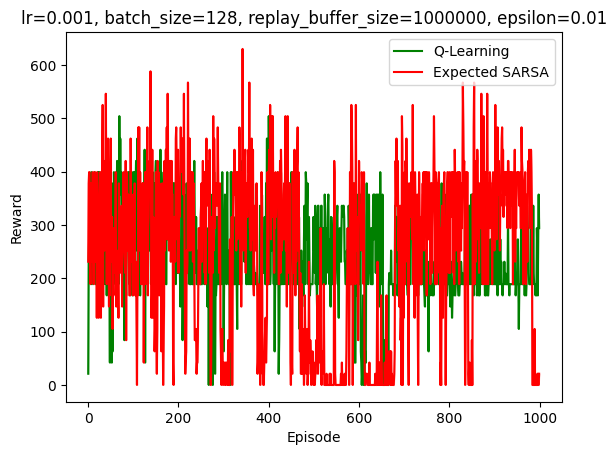

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.01_0.001_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 210.0 0.61478191614151
100 21.0 0.00016268237959593534
200 0.0 3.7413485050201416
300 21.0 0.8721779584884644
400 399.0 2.095106840133667
500 273.0 0.000481323862913996
600 42.0 0.000408640451496467
700 420.0 1.4534062147140503
800 210.0 2.836729049682617
900 0.0 5.9527482986450195
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 7.390115261077881
100 378.0 0.09491046518087387
200 483.0 0.08493434637784958
300 399.0 0.14491352438926697
400 231.0 0.22248804569244385
500 441.0 0.28031107783317566
600 336.0 0.281619131565094
700 441.0 0.2683529257774353
800 504.0 0.29093852

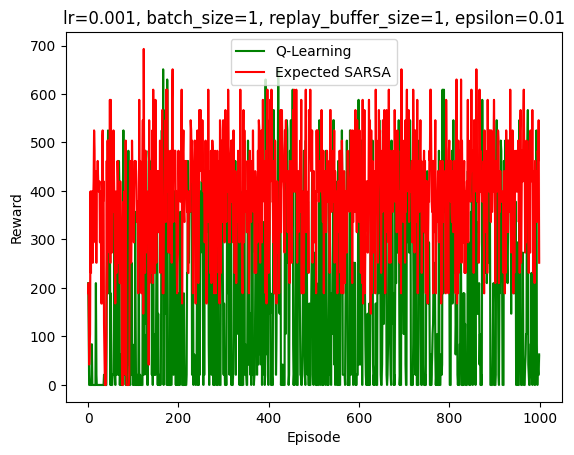

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.01_0.001_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 21.0 0.04708829149603844
100 420.0 0.08530326932668686
200 252.0 0.07234127819538116
300 504.0 0.0339287631213665
400 420.0 0.03234584629535675
500 441.0 0.04583952948451042
600 399.0 0.034040991216897964
700 399.0 0.036495812237262726
800 462.0 0.08917059004306793
900 336.0 0.040898509323596954
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 189.0 0.14425039291381836
100 357.0 0.6520496010780334
200 441.0 0.04375727102160454
300 294.0 0.10718654096126556
400 168.0 0.0548749640583992
500 168.0 0.0366656593978405
600 315.0 0.03575650602579117
700 336.0 0.07689269632101059
800 

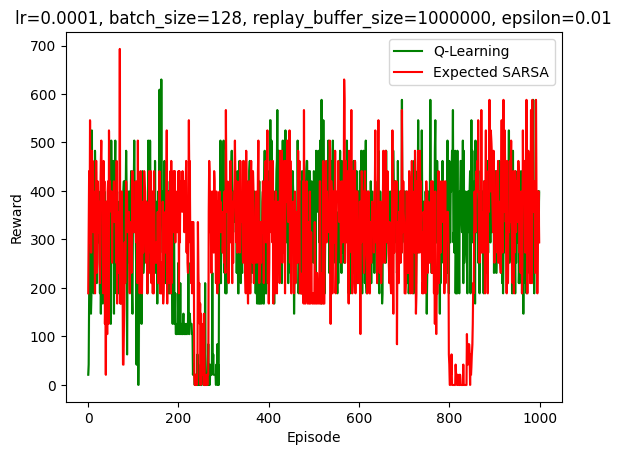

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.01_0.0001_128.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/1
Q-Learning
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 42.0 3.875484708260046e-06
100 189.0 0.00865384005010128
200 357.0 0.010479752905666828
300 189.0 0.0841277688741684
400 189.0 12.217120170593262
500 336.0 32.336570739746094
600 189.0 0.0304906964302063
700 63.0 77.93387603759766
800 210.0 30.20761489868164
900 252.0 77.80412292480469
Expected SARSA
initializing layer Linear(in_features=128, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=7, bias=True)
0 0.0 0.0006322147091850638
100 399.0 0.5743023157119751
200 189.0 0.010603372938930988
300 189.0 1.7397898435592651
400 399.0 0.03702617809176445
500 399.0 14.792033195495605
600 378.0 3.825756549835205
700 441.0 31.221593856811523
800 168.0 12.090

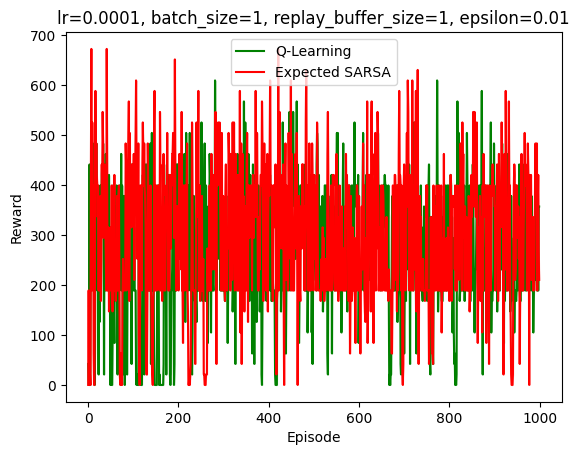

mv: rename plot.png to plots/ALE/Assault-ram-v5_0.01_0.0001_1.png: No such file or directory
rm: plot.png: No such file or directory


Run 1/2
Run 2/2


IndexError: index 1 is out of bounds for axis 0 with size 1

In [2]:
epsilons = [0.25, 0.1, 0.01]

# lrs = [1/4, 1/8, 1/16]

lrs = [0.01, 0.001, 0.0001]
replay_buffers = [(128, 1000000), (1, 1)]
for i in range(1, 10):
    SEEDS = i
    for epsilon in epsilons:
        for lr in lrs:
            for replay_buffer in replay_buffers:
                run_experiment(lr, replay_buffer[0], replay_buffer[1], epsilon)
                time.sleep(1)
                os.system('mv plot.png plots/{}_{}_{}_{}.png'.format(env_name, epsilon, lr, replay_buffer[0]))
                time.sleep(1)
                os.system('rm plot.png')
                time.sleep(1)


18
[array([[147., 273., 168., 231., 399., 336., 378., 252., 210., 336., 273.,
        567., 294., 210., 189., 336., 189., 189., 357., 189., 357., 273.,
        315., 210., 231., 252., 357., 483., 189., 252., 336., 441., 189.,
        252., 168., 357., 189., 378., 168., 168., 126., 252., 420., 189.,
        189., 378., 231., 336., 189., 231., 252., 252., 420., 399., 252.,
        441., 336., 420., 483., 147., 294., 315., 231., 399., 189., 210.,
        189., 273., 378., 420., 357., 399., 315., 294.,  63., 378., 210.,
        189., 378., 336., 336., 189., 147., 252., 294., 252., 210., 252.,
        336., 315., 231., 357., 357., 399., 168., 294., 189., 399., 231.,
        378., 336., 294., 252., 441., 336., 189., 357., 273., 399., 357.,
        483., 546., 294., 252., 189., 273., 210., 210., 336., 336., 210.,
        231., 378., 399., 168., 189., 273.,  84., 147., 147., 315., 357.,
        168., 420., 315., 231., 483., 294., 189., 231., 315., 231., 399.,
        357., 252., 294., 420., 18

ValueError: 'y1' is not 1-dimensional

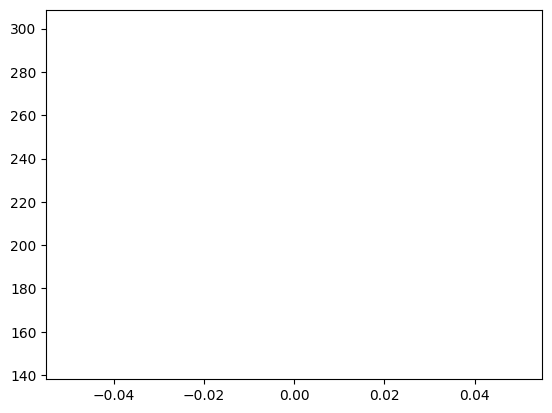

In [ ]:
### Plotting
### READ ALL PKL FILES STARTING WITH 'q_learning_rewards' and 'expected_sarsa_rewards'
### PLOT THE MEAN AND STD OF THE REWARDS
### SAVE THE PLOT AS 'plot.png'
### MOVE THE PLOT TO 'plots' DIRECTORY

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

files = os.listdir()
q_learning_rewards = []
expected_sarsa_rewards = []
for file in files:
    if file.startswith('q_learning_rewards'):
        q_learning_rewards.append(pickle.load(open(file, 'rb')))
    if file.startswith('expected_sarsa_rewards'):
        expected_sarsa_rewards.append(pickle.load(open(file, 'rb')))
print(len(q_learning_rewards))
print(expected_sarsa_rewards)
q_learning_rewards_mean = np.mean(q_learning_rewards, axis=0)
q_learning_rewards_std = np.std(q_learning_rewards, axis=0)/np.sqrt(len(q_learning_rewards))
expected_sarsa_rewards_mean = np.mean(expected_sarsa_rewards, axis=0)
expected_sarsa_rewards_std = np.std(expected_sarsa_rewards, axis=0)/np.sqrt(len(expected_sarsa_rewards))
plt.plot(q_learning_rewards_mean, label='Q-Learning', color='green')
plt.fill_between(range(EPISODES), q_learning_rewards_mean - q_learning_rewards_std, q_learning_rewards_mean + q_learning_rewards_std, color='green', alpha=0.2)
plt.plot(expected_sarsa_rewards_mean, label='Expected SARSA', color='red')
plt.fill_between(range(EPISODES), expected_sarsa_rewards_mean - expected_sarsa_rewards_std, expected_sarsa_rewards_mean + expected_sarsa_rewards_std, color='red', alpha=0.2)
plt.title('Q-Learning vs Expected SARSA')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.savefig('plot.png')
plt.show()
os.system('mv plot.png plots/plot.png')
os.system('rm plot.png')
